# Introduction
A couple of months ago Keras added CuDNNLSTM and CuDNNGRU layers, which are special implementations of the regular LSTM and GRU layers backed by NVIDIA's cuDNN library. This means that if you have access to a CUDA GPU, training recurrent neural networks just got a whole lot faster.

In this blogpost I'll be showing a simple implementation of an LSTM network and compare the computations times of a network implemented in the CuDDNLSTM layer with one implemented with the regular LSTM layer. I will also be using this opportunity to explore the PTB Diagnostic ECG Database (https://www.physionet.org/physiobank/database/ptbdb/), a database containing ECG data of 290 subjects of which some have a particular heart disease.



# Recurrent neural networks & LSTMs



In [1]:
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import CuDNNLSTM, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import time
import keras

C:\Users\lnies\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}    

In [99]:
record_names

['patient001/s0010_re',
 'patient001/s0014lre',
 'patient001/s0016lre',
 'patient002/s0015lre',
 'patient003/s0017lre',
 'patient004/s0020are',
 'patient004/s0020bre',
 'patient005/s0021are',
 'patient005/s0021bre',
 'patient005/s0025lre',
 'patient005/s0031lre',
 'patient005/s0101lre',
 'patient006/s0022lre',
 'patient006/s0027lre',
 'patient006/s0064lre',
 'patient007/s0026lre',
 'patient007/s0029lre',
 'patient007/s0038lre',
 'patient007/s0078lre',
 'patient008/s0028lre',
 'patient008/s0037lre',
 'patient008/s0068lre',
 'patient009/s0035_re',
 'patient010/s0036lre',
 'patient010/s0042lre',
 'patient010/s0061lre',
 'patient011/s0039lre',
 'patient011/s0044lre',
 'patient011/s0049lre',
 'patient011/s0067lre',
 'patient012/s0043lre',
 'patient012/s0050lre',
 'patient013/s0045lre',
 'patient013/s0051lre',
 'patient013/s0072lre',
 'patient014/s0046lre',
 'patient014/s0056lre',
 'patient014/s0071lre',
 'patient015/s0047lre',
 'patient015/s0057lre',
 'patient015/s0152lre',
 'patient016/s00

In [3]:
data_folder = 'data'
db = 'ptbdb'
record_names = io.get_record_list(db)

In [4]:
def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()
    
    row['channels'] = channels
    
    for channel, signal in zip(channels, signals):
        row[channel] = signal
        
    return row

In [6]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})
    
channels = record.sig_name
df_records = pd.DataFrame(records)    

In [7]:
labels = df_records['label'].unique()
df_records['label'].value_counts()

Myocardial infarction     368
Healthy control            80
n/a                        27
Bundle branch block        17
Cardiomyopathy             17
Dysrhythmia                16
Hypertrophy                 7
Valvular heart disease      6
Myocarditis                 4
Stable angina               2
Heart failure (NYHA 3)      1
Heart failure (NYHA 2)      1
Unstable angina             1
Palpitation                 1
Heart failure (NYHA 4)      1
Name: label, dtype: int64

In [8]:
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

In [19]:
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
    
#df_selected['patient'].sample(len())

In [22]:
def make_set(df_data, channels, label_map, record_id, window_size=2048):
    n_windows = 0
    
    for _, record in tqdm(df_data.iterrows()):
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join('data', record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list

In [23]:
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048#df_records['signal_length'].min()
#trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

In [31]:
def make_model(input_shape, output_dim, lstm_layer, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(lstm_layer(256, return_sequences=True, input_shape=input_shape, batch_size=None))
    model.add(Dropout(dropout))
    model.add(lstm_layer(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [29]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [32]:
np.random.seed(1337)
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
    
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048#df_records['signal_length'].min()
trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

#Shuffle order of train set
trainX, trainY = shuffle(trainX, trainY)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

#df_selected['patient'].sample(len())

filepath = os.path.join('models', "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'two_classes'
model_folder = os.path.join('tensorlogs', model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))
    
tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
time_callback = TimeHistory()
callbacks = [checkpoint, tensorboard_callback, time_callback]

model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1], CuDNNLSTM)

model.fit(trainX, trainY, epochs=50, batch_size=512, sample_weight=weights, callbacks=callbacks)



model dim:  (15, 2048) 2
Epoch 1/50
19910/19910 [==============================] - ETA: 1:57 - loss: 0.212 - ETA: 1:00 - loss: 0.217 - ETA: 41s - loss: 0.213 - ETA: 31s - loss: 0.21 - ETA: 26s - loss: 0.20 - ETA: 22s - loss: 0.21 - ETA: 19s - loss: 0.20 - ETA: 17s - loss: 0.20 - ETA: 15s - loss: 0.20 - ETA: 14s - loss: 0.20 - ETA: 12s - loss: 0.20 - ETA: 11s - loss: 0.20 - ETA: 10s - loss: 0.20 - ETA: 9s - loss: 0.2039 - ETA: 9s - loss: 0.202 - ETA: 8s - loss: 0.201 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.201 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.198 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.197 - ETA: 4s - loss: 0.196 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.194 - ETA: 3s - loss: 0.194 - ETA: 3s - loss: 0.193 - ETA: 3s - loss: 0.193 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.190 - ETA: 1s - loss: 0.190 - ETA: 1s - loss: 0.189 - ETA: 1s - loss: 0.188 - ETA: 1s - loss: 0.187 - ETA: 0s - loss: 0.186 - ETA: 0s - loss: 0.186 - ETA: 0s - loss: 0.185 

19910/19910 [==============================] - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.015 - ETA: 6s - loss: 0.014 - ETA: 6s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - 7s 340us/step - loss: 0.0185

Epoch 00015

19910/19910 [==============================] - ETA: 6s - loss: 0.006 - ETA: 6s - loss: 0.008 - ETA: 6s - loss: 0.006 - ETA: 5s - loss: 0.008 - ETA: 5s - loss: 0.008 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.008 - ETA: 5s - loss: 0.008 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 7s 334us/step - loss: 0.0075

Epoch 00029

19910/19910 [==============================] - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.006 - ETA: 7s - loss: 0.004 - ETA: 7s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 8s 392us/step - loss: 0.0045

Epoch 00043

In [33]:
output = model.predict_classes(testX)

In [34]:
confusion_matrix(testY.argmax(axis=1), output)

array([[ 619,  278],
       [ 404, 3348]], dtype=int64)

In [81]:
(output == testY.argmax(axis=1)).sum()/len(output)

0.8466336846633684

In [62]:
summed = pd.DataFrame({'record':record_list, 'predictions':output, 'label':testY.argmax(axis=1)}).groupby('record').mean()
control = summed.loc[summed['label'] == 0]
print("Control accuracy: "+  str((control['predictions'] <= 0.5).sum()/control.shape[0]))

infarct = summed.loc[summed['label'] == 1]
print("Infarct accuracy: "+  str((infarct['predictions'] > 0.5).sum()/infarct.shape[0]))

Control accuracy: 0.75
Infarct accuracy: 0.9701492537313433


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000294A55AA978>,
      dtype=object)

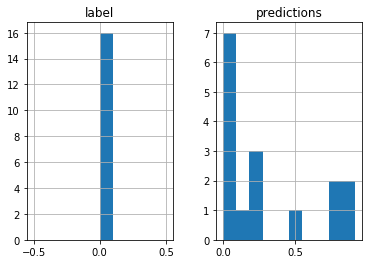

In [65]:
control.hist()

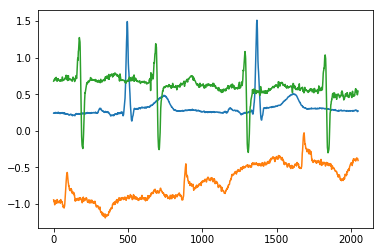

In [19]:
channel = channels[1]
plt.plot(df_healthy.iloc[3][channel][0:window_size])
plt.plot(df_myo.iloc[4][channel][0:window_size])
plt.plot(df_dys.iloc[2][channel][0:window_size])
plt.show()

In [68]:
record.label = comments_to_dict(record.comments)['Reason for admission']

In [69]:
record.label

' Myocardial infarction'

In [66]:
comments_to_dict(record.comments)

{'Acute infarction (localization)': ' infero-latera',
 'Additional diagnoses': ' Diabetes mellitus',
 'Additional medication': ' Heparin Isosorbit-Mononitrate ASA Diazepam',
 'Admission date': ' 29-Sep-90',
 'Aorta (at rest) (syst/diast)': ' 160/64 cmH2O',
 'Aorta (at rest) mean': ' 106 cmH2O',
 'Cardiac index (at rest)': ' n/a',
 'Cardiac index (load)': ' n/a',
 'Cardiac output (at rest)': ' n/a',
 'Cardiac output (load)': ' n/a',
 'Catheterization date': ' 16-Oct-90',
 'Chest X-ray': ' Heart size upper limit of norm',
 'Diagnose': '',
 'Dosage (lytic agent)': ' 30 mg',
 'ECG date': ' 18/10/1990',
 'Echocardiography': ' n/a',
 'Former infarction (localization)': ' no',
 'Hemodynamics': '',
 'In hospital medication': ' ASA Isosorbit-Mononitrate Ca-antagonist Amiloride+Chlorothiazide Glibenclamide Insulin',
 'Infarction date': ' 29-Sep-90',
 'Infarction date (acute)': ' 29-Sep-90',
 'Left coronary artery stenoses (RCX)': ' No stenoses',
 'Left coronary artery stenoses (RIVA)': ' RIVA 70

In [4]:
io.dl_database(db, 'data', records)

Finished downloading files
